# <a id='toc1_'></a>[test area](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [test area](#toc1_)    
    - [load](#toc1_1_1_)    
  - [pls](#toc1_2_)    
    - [bars](#toc1_2_1_)    
    - [histo](#toc1_2_2_)    
    - [box](#toc1_2_3_)    
    - [pie](#toc1_2_4_)    
    - [join](#toc1_2_5_)    
    - [sankey](#toc1_2_6_)    
  - [tbl](#toc1_3_)    
    - [print_summary()](#toc1_3_1_)    
    - [describe_df()](#toc1_3_2_)    
    - [descr_db()](#toc1_3_3_)    
  - [show num](#toc1_4_)    
  - [venn](#toc1_5_)    
  - [hlp](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[load](#toc0_)

In [1]:
from pathlib import Path
import os
import seaborn as sb
import pandas as pd
import sys
import numpy as np
# from datetime import datetime
# from connection_helper import sql

from pandas_plots import tbl, pls, ven , hlp
import duckdb as ddb

hlp.show_package_version(["matplotlib_venn", "dataframe_image", "plotly", "kaleido", "seaborn"], )
df = sb.load_dataset('taxis')

# os.environ["RENDERER"] = "svg"
os.environ["THEME"] = "dark"

dir_db=Path("C://temp") if hlp.get_os(hlp.OperatingSystem.WINDOWS) else Path(os.path.expanduser("~/tmp"))

file_db_clin = dir_db/'2025-11-11_data_clin.duckdb'

if not file_db_clin.is_file():
    print(f"File does not exist: {file_db_clin}")
    raise FileNotFoundError


🐍 3.12.9 | 📦 matplotlib_venn: 0.11.10 | 📦 dataframe_image: 0.2.7 | 📦 plotly: 6.2.0 | 📦 kaleido: 1.0.0 | 📦 seaborn: 0.13.2 | 📦 pandas: 2.3.1 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.3.2 | 📦 pandas-plots: 0.23.1 | 📦 connection-helper: 0.13.1


In [2]:
con = ddb.connect(file_db_clin, read_only=True)

In [3]:
# --- Example Usage ---
query= "from Tumor where z_dy = 2023"
filters = [
    ("z_icd10_3d = 'C50'", "C50"),
    # ("z_dy = 2023", "lkdhglkdhgldgdgkjdgflkjdgfkjld"),
]
hlp.get_duckdb_filter_n(
    con,
    query,
    filters,
    distinct_metric="z_pat_id",
)
# hlp.get_duckdb_filter_n()


<!-- START_TOKEN -->

counts: distinct z_pat_id
---
n = 701_806          (100.0%) ██████████████████████████████
└ [C50]:  n = 76_975  (11.0%) ░░░░░░░░░░░░░░░░░░░░░░░░░░░███


<!-- END_TOKEN -->

In [4]:
db_delay = con.sql("""--sql
    select
            first(z_kkr_label) as z_kkr_label,
            first(z_first_treatment_after_days) as z_first_treatment_after_days, 
            first(z_first_treatment) as z_first_treatment
    from Tumor
    where ifnull(z_first_treatment,'') <> ''
    and z_dy = 2023 and z_icd10_3d = 'C81'
    group by z_tum_id
    """)

In [5]:
db_tum = con.sql("""select * from Tumor""")

🗄️ db	2_265_000, 4
	("has_gesamt, has_lokal, has_lymph, has_fm")
┌────────────┬───────────┬───────────┬─────────┐
│ has_gesamt │ has_lokal │ has_lymph │ has_fm  │
│  boolean   │  boolean  │  boolean  │ boolean │
├────────────┼───────────┼───────────┼─────────┤
│ false      │ false     │ false     │ false   │
│ false      │ NULL      │ NULL      │ NULL    │
│ false      │ false     │ false     │ false   │
└────────────┴───────────┴───────────┴─────────┘

n = 2_265_000 | n(true) = 152_567 | n(nonempty) = 118_533


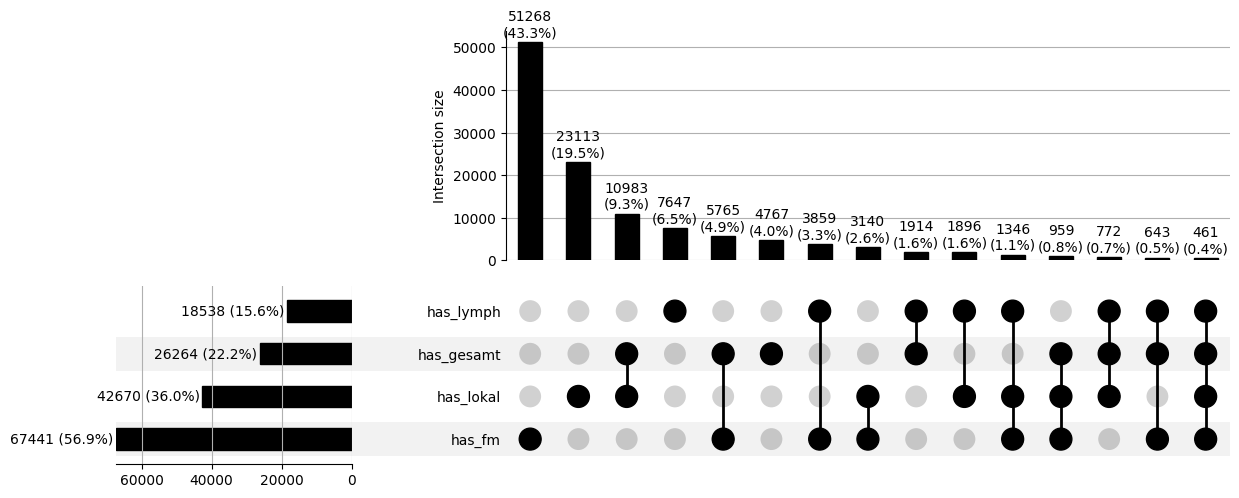

In [9]:
db_upset = con.sql("""--sql
    select
        --fol.Gesamtbeurteilung_Tumorstatus,
        --fol.Verlauf_Lokaler_Tumorstatus,
        --fol.Verlauf_Tumorstatus_Lymphknoten,
        --fol.Verlauf_Tumorstatus_Fernmetastasen,
        (Gesamtbeurteilung_Tumorstatus ==  'Y') as has_gesamt,
        (Verlauf_Lokaler_Tumorstatus == 'R') as has_lokal,
        (Verlauf_Tumorstatus_Lymphknoten == 'R') as has_lymph,
        (Verlauf_Tumorstatus_Fernmetastasen == 'R') as has_fm,
        --coalesce((Gesamtbeurteilung_Tumorstatus ==  'Y'), false) as has_gesamt,
        --coalesce((Verlauf_Lokaler_Tumorstatus == 'R'), false) as has_lokal,
        --coalesce((Verlauf_Tumorstatus_Lymphknoten == 'R'), false) as has_lymph,
        --coalesce((Verlauf_Tumorstatus_Fernmetastasen == 'R'), false) as has_fm,
        --count(*) as cnt,
    from Folgeereignis fol
    --group by all
""")
tbl.descr_db(db_upset)

pls.plot_upset(
    db_upset.to_df(),
    # size=40,
    # show_percentages=True,
    # include_empty_subsets=True,
    include_false_subsets=False,
    # sort_by="input",
    orientation="horizontal",
    # show_n=False,
)

## <a id='toc1_2_'></a>[pls](#toc0_)

### <a id='toc1_2_1_'></a>[bars](#toc0_)

In [17]:
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    # height=400,
    # width=1000,
    # use_ci=True,
    # ci_agg='median',
)
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    height=600,
    use_ci=True,
    ci_agg='median',
)

In [18]:
df_delay_kkr = (db_delay
    .project("""
            z_kkr_label,
            case when z_kkr_label = '05-NW' then null else z_first_treatment end as z_first_treatment,
            --z_first_treatment
            """)
    .filter("left(z_kkr_label,2)::int8 in (2,5,9,15)")
    .to_df()
    # .iloc[:,[0,3]]
    )
# df_delay_kkr.sum()
display(df_delay_kkr.sort_values(["z_kkr_label","z_first_treatment"]))
pls.plot_stacked_bars(
    df_delay_kkr,
    height=600,
    width=1600,
    orientation="h",
    relative=True,
    show_pct_bar=True,
    kkr_col="z_kkr_label",
    # renderer="png",
    )


,z_kkr_label,z_first_treatment
19,02-HH,op
55,02-HH,op
85,02-HH,op
86,02-HH,op
100,02-HH,op
...,...,...
572,15-ST,sy
576,15-ST,sy
614,15-ST,sy
622,15-ST,sy


,z_dy,tu,z_kkr_label,cnt
0,2020,06,13-MV,1
1,2020,30,13-MV,1
2,2020,###,13-MV,21
3,2020,18,11-BE,1
4,2020,18.,13-MV,1
...,...,...,...,...
16352,2023,S37,14-SN,1
16353,2023,S72,11-BE,1
16354,2023,Z22,14-SN,1
16355,2023,Z85,14-SN,1


z_dy            int64
tu             object
z_kkr_label    object
cnt             int64
dtype: object


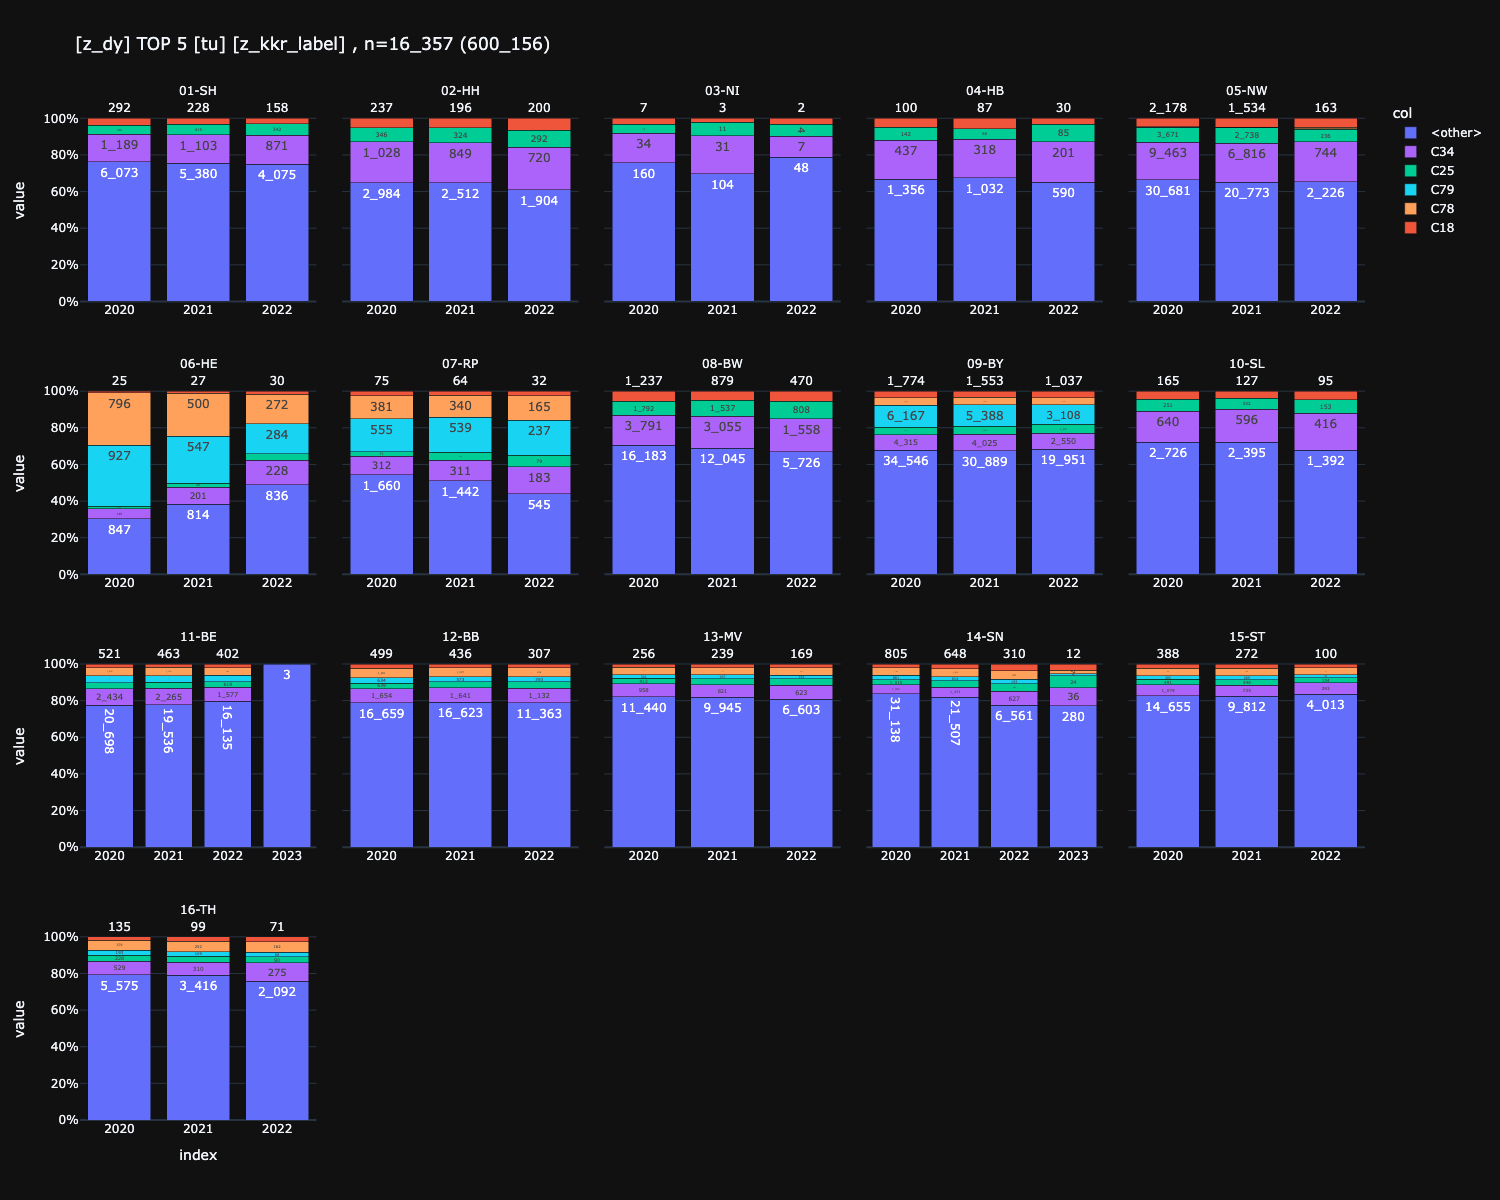

In [19]:
df_facets = pd.read_csv("assets/facets.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_facets[:None])
print(df_facets.dtypes)

_df = df_facets[
    [
        "z_dy",
        "tu",
        "z_kkr_label",
        "cnt",
    ]
]#[:100]
# _df


l=pls.plot_facet_stacked_bars(
    _df,
    top_n_color=5,
    # subplots_per_row=3,
    # top_n_facet=15,
    # top_n_index=3, 
    show_other=True,
    sort_values_color=True,
    # sort_values_facet=True,
    relative=True,
    # show_pct=True,
    annotations=True,
    subplot_size=300,
    subplots_per_row=5,
    # renderer="",
    # show_pct=True,
    )
# l

# ll = pls.plot_facet_stacked_bars(
#     _df,
#     top_n_color=5,
#     # subplots_per_row=8,
#     # top_n_facet=15,
#     # top_n_index=3, 
#     show_other=True,
#     sort_values_color=True,
#     # sort_values_facet=True,
#     relative=True,
#     annotations=True,
#     )
# # ll

### <a id='toc1_2_2_'></a>[histo](#toc0_)

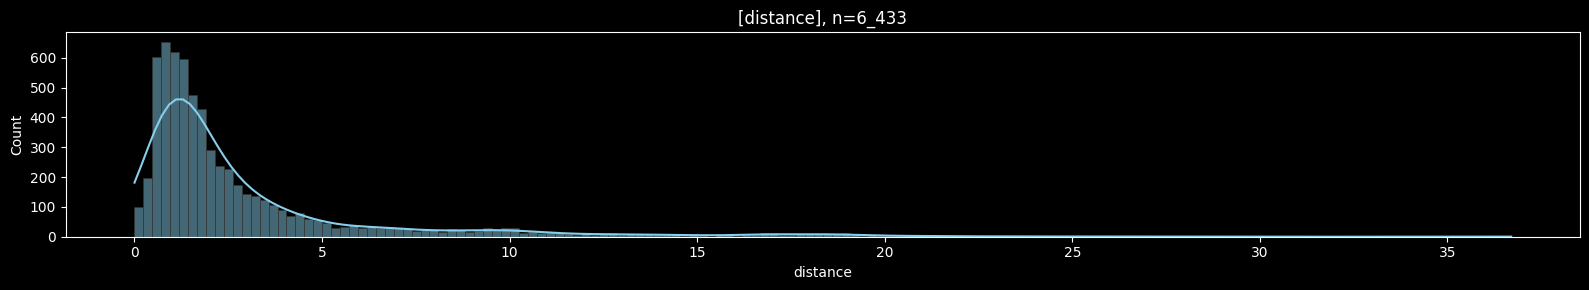


column (n = 6_433) |   present    |  min  | lower |  q25  | median | mean  |  q75  | upper |  max   |  std  |  cv  
-------------------+--------------+-------+-------+-------+--------+-------+-------+-------+--------+-------+------
distance           | 6_433 (100%) | 0.000 | 0.000 | 0.980 |  1.640 | 3.025 | 3.210 | 6.550 | 36.700 | 3.828 | 1.266



In [20]:
_=pls.plot_histogram_large(
    df.distance,
    # nbins=50,
    height=300,
    summary=True
)

In [21]:
# _df = df["distance"]
# # _df#.to_frame()
# # _df=df[["fare","distance"]]
# pls.plot_histogram(
#     _df,
#     height=300,
#     width=1000,
#     precision=0,
#     orientation="v",
#     histnorm="",
#     nbins=-1,
#     # barmode="overlay",
#     # renderer="png",
#     # png_path=Path(".local/box5.png"),
#     summary=True,
#     caption="test lol xd-lmao",
# )

### <a id='toc1_2_3_'></a>[box](#toc0_)

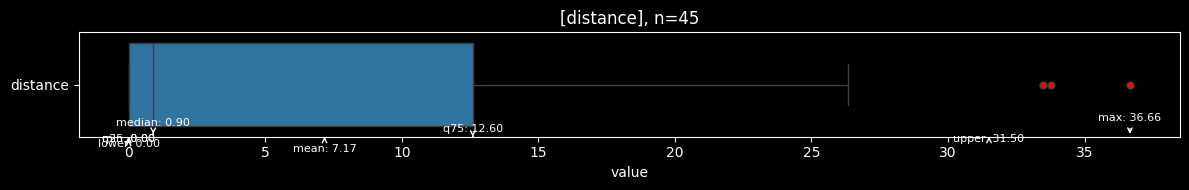


column (n = 45) |  present  |  min  | lower |  q25  | median | mean  |  q75   | upper  |  max   |  std   |  cv  
----------------+-----------+-------+-------+-------+--------+-------+--------+--------+--------+--------+------
distance        | 45 (100%) | 0.000 | 0.000 | 0.000 |  0.900 | 7.171 | 12.600 | 26.350 | 36.660 | 10.708 | 1.493



In [22]:
_=pls.plot_box_large(
    # df["distance"],
    df[df["dropoff_borough"].isna()].distance,
    height=200,
    # violin=True,
    # use_log=True,
    annotations=True,
)

     dropoff_borough  distance
0          Manhattan      1.60
1          Manhattan      0.79
2          Manhattan      1.37
3          Manhattan      7.70
4          Manhattan      2.16
...              ...       ...
6428       Manhattan      0.75
6429           Bronx     18.74
6430        Brooklyn      4.14
6431        Brooklyn      1.12
6432        Brooklyn      3.85

[6433 rows x 2 columns]


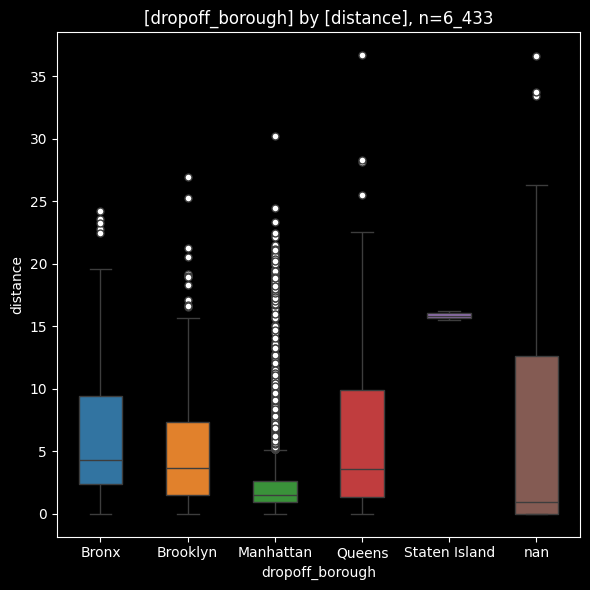


column (n = 6_433) |   present    | min  | lower | q25  | median | mean | q75  | upper |  max  | std  |  cv 
-------------------+--------------+------+-------+------+--------+------+------+-------+-------+------+-----
distance           | 6_433 (100%) | 0.00 |  0.00 | 0.98 |   1.64 | 3.02 | 3.21 |  6.55 | 36.70 | 3.83 | 1.27


item (n = 6_433) | count |  min  | lower |  q25  | median | mean  |  q75  | upper |  max  |  std  |  cv 
-----------------+-------+-------+-------+-------+--------+-------+-------+-------+-------+-------+-----
Bronx            |   137 |  0.00 |  0.00 |  2.36 |   4.31 |  6.61 |  9.44 | 19.62 | 24.20 |  5.95 | 0.90
Brooklyn         |   501 |  0.00 |  0.00 |  1.53 |   3.63 |  5.03 |  7.30 | 15.70 | 26.92 |  4.49 | 0.89
Manhattan        | 5_206 |  0.00 |  0.00 |  0.91 |   1.50 |  2.39 |  2.60 |  5.13 | 30.23 |  2.91 | 1.21
Queens           |   542 |  0.00 |  0.00 |  1.34 |   3.56 |  5.96 |  9.89 | 22.51 | 36.70 |  5.89 | 0.99
Staten Island    |     2 | 15.51 | 15.51

In [23]:
_df = df[["dropoff_borough","distance"]]
print(_df)
_=pls.plot_boxes_large(
    _df,
    width=600,
    # violin=True,
    # use_log=True,
)

# _=pls.plot_boxes(
#     _df,
#     width=600,
#     # violin=True,
#     # use_log=True,
# )


In [24]:
# pls.plot_box(
#     df.distance,
#     height=400,
#     violin=False,
#     x_min=-2,
#     x_max=50,
#     # summary = False
# )

# _df = df[["dropoff_borough", "distance"]]
# # _df["dropoff_borough"] = _df["dropoff_borough"].astype(str)
# display(_df.dtypes)
# display(_df)
# _=pls.plot_boxes(
#     _df,
#     width=1600,
#     annotations=False,
#     precision=4,
# )

### <a id='toc1_2_4_'></a>[pie](#toc0_)

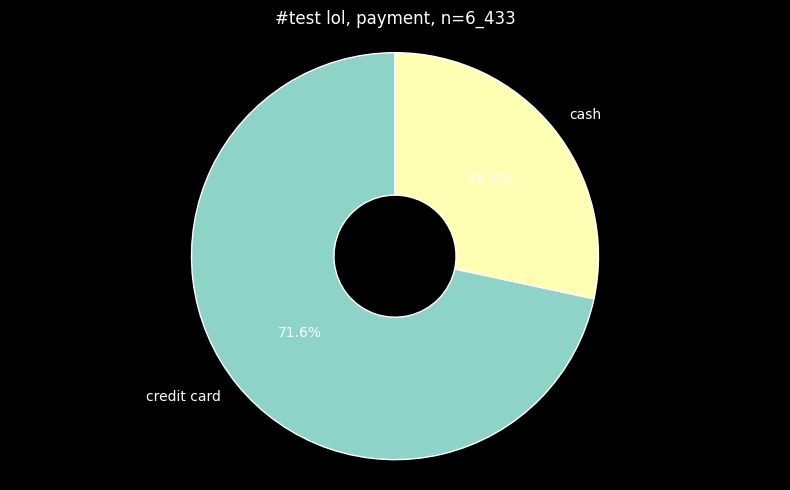

In [25]:
df["payment"]
pls.plot_pie(
    data=df["payment"],
    caption="test lol",
    donut_size=0.3,
    # precision=3,
)

### <a id='toc1_2_5_'></a>[join](#toc0_)

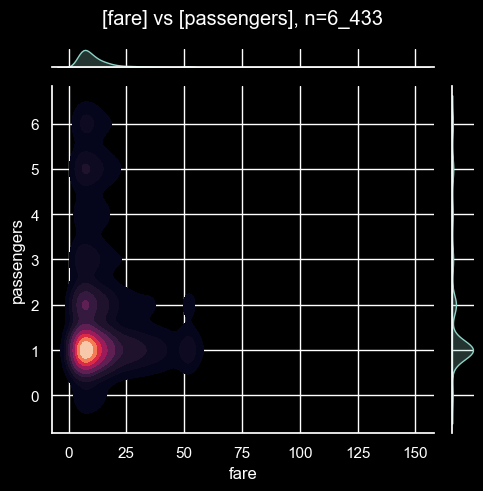

In [26]:
_df = df[["fare", "passengers"]]
# pls.plot_joint(_df, precision=0, size=15, kind="reg", caption="")
# pls.plot_joint(_df, precision=0, size=15, kind="hex", png_path=Path(".local/box6.png"))
pls.plot_joint(_df, precision=0, size=5, kind="kde",)
# pls.plot_joint(_df, precision=0, size=5, kind="hist",)
# pls.plot_joint(_df, precision=0, size=5, kind="kde", png_path=Path(".local/box7.png"))

### <a id='toc1_2_6_'></a>[sankey](#toc0_)

In [27]:
pls.plot_sankey(
    width=2000,
    font_size=15,
    # renderer="png",
)

--- Using demo data (data_demo) ---
   tumor-id diagnosis date treatment
0         1     2020-01-01        op
1         1     2021-02-01      syst
2         1     2022-03-01        op
3         1     2023-04-01       rad
4         1     2024-05-01        op
5         2     2010-01-01      syst
6         2     2011-02-01        st
7         2     2012-03-01        op
8         2     2013-04-01       rad
9         3     2015-01-01        op
10        3     2016-02-01       rad
11        3     2017-03-01      syst
12        3     2018-04-01        op
13        4     2005-01-01        st
14        4     2006-02-01      syst
15        4     2007-03-01        op
16        5     2019-01-01        op
17        5     2020-02-01       rad
18        6     2021-01-01      syst
19        6     2022-02-01        op
20        7                         
21        7                         
22        8     2025-01-01        op
23        9     2025-02-01        op
24       10     2025-03-01      syst
25

## <a id='toc1_3_'></a>[tbl](#toc0_)

### <a id='toc1_3_1_'></a>[print_summary()](#toc0_)

In [28]:
_=tbl.print_summary(df, extended=True)


column (n = 6_433) |   present    |  min  | lower |  q25   | median |  mean  |  q75   | upper  |   max   |  std   |  cv   |     sum     | skew  | kurto 
-------------------+--------------+-------+-------+--------+--------+--------+--------+--------+---------+--------+-------+-------------+-------+-------
passengers         | 6_433 (100%) |     0 |     0 |  1.000 |  1.000 |  1.539 |  2.000 |      3 |       6 |  1.204 | 0.782 |       9_902 | 2.359 |  4.881
distance           | 6_433 (100%) | 0.000 | 0.000 |  0.980 |  1.640 |  3.025 |  3.210 |  6.550 |  36.700 |  3.828 | 1.266 |  19_457.360 | 3.008 | 11.135
fare               | 6_433 (100%) | 1.000 | 1.000 |  6.500 |  9.500 | 13.091 | 15.000 | 27.540 | 150.000 | 11.552 | 0.882 |  84_214.870 | 3.217 | 17.649
tip                | 6_433 (100%) | 0.000 | 0.000 |  0.000 |  1.700 |  1.979 |  2.800 |  6.960 |  33.200 |  2.449 | 1.237 |  12_732.320 | 2.665 | 12.740
tolls              | 6_433 (100%) | 0.000 | 0.000 |  0.000 |  0.000 |  0.325 |  0

### <a id='toc1_3_2_'></a>[describe_df()](#toc0_)

In [29]:
df["lol"] = np.nan
df["xd"]=2027
df["lol"] = df["lol"].astype("float64")

display(df)

tbl.describe_df(
    df,
    # "taxis",
    # use_columns=False,
    # renderer="svg",
    top_n_uniques=10,
    top_n_chars_in_columns=10,
    top_n_chars_in_index=15,
)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,lol,xd
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,NaN,2027
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,NaN,2027
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan,NaN,2027
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan,NaN,2027
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan,NaN,2027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,East Harlem North,Central Harlem North,Manhattan,Manhattan,NaN,2027
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,Jamaica,East Concourse/Concourse Village,Queens,Bronx,NaN,2027
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,Crown Heights North,Bushwick North,Brooklyn,Brooklyn,NaN,2027
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn,NaN,2027


🔵 *** df: <unknown> ***  
🟣 shape: (6_433, 16)
🟣 duplicates: 0  
🟠 column stats all (dtype | uniques | missings) [values]  
- index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,]  
- pickup (datetime64[ns] | 6_414 | 0 (0%)) [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53,  
2019-03-01 00:29:22, 2019-03-01 00:30:59, 2019-03-01 00:32:49, 2019-03-01 00:53:00,  
2019-03-01 00:56:50, 2019-03-01 01:25:30,]  
- dropoff (datetime64[ns] | 6_425 | 0 (0%)) [2019-02-28 23:32:35, 2019-03-01 00:13:32, 2019-03-01 00:29:47, 2019-03-01 00:32:48,  
2019-03-01 00:37:39, 2019-03-01 00:47:58, 2019-03-01 00:53:18, 2019-03-01 00:58:22,  
2019-03-01 01:04:01, 2019-03-01 01:29:25,]  
- passengers (int64 | 7 | 0 (0%)) [0, 1, 2, 3, 4, 5, 6,]  
- distance (float64 | 1_079 | 0 (0%)) [0.0, 0.01, 0.02, 0.03, 0.04, 0.07, 0.08, 0.09, 0.1, 0.11,]  
- fare (float64 | 220 | 0 (0%)) [1.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5,]  
- tip (float64 | 489 | 0 (0%)) [0.0, 0.01, 0.02, 0.06, 0.08, 0.09,

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,lol,xd
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan,NaN,2027
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan,NaN,2027
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan,NaN,2027


In [30]:
tbl.describe_df(db_tum.limit(1000).to_df(), use_plot=False)

🔵 *** df: <unknown> ***  
🟣 shape: (1_000, 105)
🟣 duplicates: 0  
🟠 column stats all (dtype | uniques | missings) [values]  
- index [0, 1, 2, 3, 4,]  
- oBDS_RKIPatientTumorId (object | 1_000 | 0 (0%)) ['00427dbf-4acf-468e-9b5c-8f5f5a7cf1d3', '00e61412-981d-4b2f-b330-6a32e8632f08',  
'00eb0411-b445-43cd-8991-4b799ec7873a', '00ee3e10-2024-4ded-9c7a-d0e606d19767',  
'0101ebfe-14d4-4974-9edc-0c04a1c8de43',]  
- oBDS_RKIPatientId (object | 886 | 0 (0%)) ['0058eed9-bc0b-44d7-9c82-ddafed8a39ea', '00ba939d-6368-493d-a652-87e58e7055fd',  
'00d3b142-9bea-4a5c-9cad-2d2bf10b7039', '00dffb20-2962-4f9e-ada5-6bc200e58473',  
'00e4c2f0-9c3c-431a-9f13-28010120c376',]  
- Diagnosedatum (datetime64[us] | 115 | 0 (0%)) [1900-04-01 00:00:00, 1997-11-15 00:00:00, 1998-05-15 00:00:00, 1998-12-15 00:00:00,  
2000-12-15 00:00:00,]  
- Diagnosedatum_Genauigkeit (object | 3 | 0 (0%)) ['M', 'T', 'V',]  
- Inzidenzort (object | 287 | 0 (0%)) ['01001', '01002', '01003', '01051', '01053',]  
- Diagnose_ICD10_Code 

,oBDS_RKIPatientTumorId,oBDS_RKIPatientId,Diagnosedatum,Diagnosedatum_Genauigkeit,Inzidenzort,Diagnose_ICD10_Code,Diagnose_ICD10_Version,Topographie_Code,Topographie_Version,Diagnosesicherung,...,z_tum_fo_count,z_first_treatment,z_first_treatment_after_days,z_event_order,z_events,z_class_hpv,z_tum_order,z_sex,z_period_diag_death_day,z_period_diag_psa_day
0,6f105957-7bbb-41f3-a302-d6a416881179,6fe288a8-24d6-451d-b30b-d272df8f7c32,2022-12-15,T,05382,C44.3,102022GM,C44.3,33,7,...,0,<NA>,<NA>,<NA>,-,<NA>,1,W,<NA>,<NA>
1,2334f59e-74ee-477c-b0c8-cadf598062e8,c2490ae9-4489-4b9a-8254-6d6b7df5781c,2022-05-15,T,05162,C16.0,102022GM,C16.0,33,7,...,0,<NA>,<NA>,<NA>,-,<NA>,1,W,143,<NA>
2,eb2ae3f0-31a2-4d2f-acd9-6d0897d22d3a,32d7f226-18c2-41b8-afae-86714267f274,2023-10-15,T,04011,C80.0,102023GM,C80.9,33,0,...,0,<NA>,<NA>,<NA>,-,<NA>,1,W,0,<NA>


### <a id='toc1_3_3_'></a>[descr_db()](#toc0_)

In [31]:
tbl.descr_db(db_delay, caption="delay", width=200)

🗄️ delay	1_724, 3
	("z_kkr_label, z_first_treatment_after_days, z_first_treatment")
┌─────────────┬──────────────────────────────┬───────────────────┐
│ z_kkr_label │ z_first_treatment_after_days │ z_first_treatment │
│   varchar   │            int32             │      varchar      │
├─────────────┼──────────────────────────────┼───────────────────┤
│ 12-BB       │                           22 │ sy                │
│ 05-NW       │                           27 │ sy                │
│ 08-BW       │                           61 │ sy                │
└─────────────┴──────────────────────────────┴───────────────────┘



In [32]:
df_dsich = pd.read_csv("assets/dsich.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_dsich[:3])
# print(df_dsich.dtypes)

,id,bl,label,cnt
0,0,01-SH,7 - Histologie Primärtumor,14351
1,22,01-SH,3 - Todesbescheinigung (DCO),1004
2,23,01-SH,5 - Zytologie,146


In [33]:
_df = df_dsich[
    [
        "bl",
        "label",
        "cnt",
    ]
].sort_values("bl")

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    height=600,
    # top_n_color=5,
    # sort_values_index=True,
    sort_values_color=True,
    # top_n_index=3,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
    kkr_col="bl",
)
_

In [34]:
_df = df_facets[
    [
        "z_kkr_label",
        "z_dy",
        "cnt",
    ]
]#.astype({"z_dy": str})

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    height=1000,
    top_n_color=10,
    # sort_values_index=True,
    # sort_values_color=True,
    # top_n_index=5,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
    # renderer="png",
)
_

In [35]:
_df = df_facets[
    [
        "z_kkr_label",
        "cnt",
    ]
]
_df

_ = pls.plot_bars(
    _df,
    height=600,
    width=1200,
    sort_values=True,
    # renderer="png",
)

In [36]:
_df = df[["color","payment","pickup_borough","total"]]
_df
# _=pls.plot_stacked_bars(_df[["color","payment","total"]],)
tbl.describe_df(_df, "taxis")

🔵 *** df: taxis ***  
🟣 shape: (6_433, 4)
🟣 duplicates: 4_803  
🟠 column stats all (dtype | uniques | missings) [values]  
- index [0, 1, 2, 3, 4,]  
- color (object | 2 | 0 (0%)) ['green', 'yellow',]  
- payment (object | 3 | 44 (1%)) ['<NA>', 'cash', 'credit card',]  
- pickup_borough (object | 5 | 26 (0%)) ['<NA>', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',]  
- total (float64 | 898 | 0 (0%)) [1.3, 3.3, 3.31, 3.8, 4.3,]  

🟠 column stats numeric  

column (n = 6_433) |   present    |  min  | lower |  q25   | median |  mean  |  q75   | upper  |   max   |  std   |  cv  
-------------------+--------------+-------+-------+--------+--------+--------+--------+--------+---------+--------+------
total              | 6_433 (100%) | 1.300 | 1.300 | 10.800 | 14.160 | 18.518 | 20.300 | 34.550 | 174.820 | 13.816 | 0.746



,color,payment,pickup_borough,total
0,yellow,credit card,Manhattan,12.95
1,yellow,cash,Manhattan,9.30
2,yellow,credit card,Manhattan,14.16


In [37]:
db = con.from_df(df)
tbl.descr_db(db, caption="taxis",)

🗄️ taxis	6_433, 16
	("pickup, dropoff, passengers, distance, fare, tip, tolls, total, color, payment, pickup_zone, dropoff_zone, pickup_borough, dropoff_borough, lol, xd")
┌─────────────────────┬─────────────────────┬────────────┬──────────┬────────┬────────┬────────┬────────┬─────────┬─────────────┬───────────────────────┬───────────────────────┬────────────────┬─────────────────┬────────┬───────┐
│       pickup        │       dropoff       │ passengers │ distance │  fare  │  tip   │ tolls  │ total  │  color  │   payment   │      pickup_zone      │     dropoff_zone      │ pickup_borough │ dropoff_borough │  lol   │  xd   │
│    timestamp_ns     │    timestamp_ns     │   int64    │  double  │ double │ double │ double │ double │ varchar │   varchar   │        varchar        │        varchar        │    varchar     │     varchar     │ double │ int64 │
├─────────────────────┼─────────────────────┼────────────┼──────────┼────────┼────────┼────────┼────────┼─────────┼─────────────┼─────────

## <a id='toc1_4_'></a>[show num](#toc0_)

In [38]:
from pathlib import Path

_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)
tbl.show_num_df(
    _df,
    total_mode="sum",
    total_axis="y",
    data_bar_axis="",
    pct_axis="xy",
    precision=0,
    heatmap_axis="xy",
    # kpi_mode="max_min_x",
    total_exclude=True,
    # kpi_mode="min_max_xy",
    kpi_mode="rag_abs",
    kpi_rag_list=(100, 1000),
    # swap=True,
    font_size_td=12,
    font_size_th=14,
    # png_path=Path("test.png"),
)

payment,cash,credit card,nan,Total
color,,,,
green,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,20 (0.0%) 🟩,13_788 (16.4%) 🟥
yellow,17_012 (20.2%) 🟥,52_907 (62.8%) 🟥,508 (0.6%) 🟨,70_427 (83.6%) 🟥


In [39]:
_df=df[["color", "payment", "fare"]]
tbl.pivot_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

payment,nan,cash,credit card,Total
color,,,,
green,20 (0.0%) 🟥,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,13_788 (16.4%) 🟥
yellow,508 (0.6%) 🟩,17_012 (20.2%) 🟩,52_907 (62.8%) 🟩,70_427 (83.6%) 🟩
Total,528 (0.6%) ⬛,21_006 (24.9%) ⬛,62_681 (74.4%) ⬛,84_215 (100.0%) ⬛


In [40]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
tbl.show_num_df(
    _df,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

,distance,fare,tip,tolls,Total
0,1.600 (2.0%),7.000 (8.7%),2.150 (2.7%),0,10.750 (13.3%)
1,0.790 (1.0%),5.000 (6.2%),0,0,5.790 (7.2%)
2,1.370 (1.7%),7.500 (9.3%),2.360 (2.9%),0,11.230 (13.9%)
3,7.700 (9.5%),27.000 (33.4%),6.150 (7.6%),0,40.850 (50.5%)
4,2.160 (2.7%),9.000 (11.1%),1.100 (1.4%),0,12.260 (15.2%)
Total,13.620 (16.8%),55.500 (68.6%),11.760 (14.5%),0,80.880 (100.0%)


In [41]:
display(df_delay_kkr)
lol=tbl.pivot_df(
    df=df_delay_kkr,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
    kkr_col="z_kkr_label",
)

display(lol)

,z_kkr_label,z_first_treatment
0,09-BY,op
1,05-NW,None
2,05-NW,None
3,05-NW,None
4,05-NW,None
...,...,...
656,09-BY,sy
657,05-NW,None
658,05-NW,None
659,15-ST,sy


z_first_treatment,,op,st,sy,Total
z_kkr_label,,,,,
01-SH,0,0,0,0,0
02-HH,0,18.000 (2.7%),4.000 (0.6%),28.000 (4.2%),50.000 (7.6%)
03-NI,0,0,0,0,0
04-HB,0,0,0,0,0
05-NW,352.000 (53.3%),0,0,0,352.000 (53.3%)
06-HE,0,0,0,0,0
07-RP,0,0,0,0,0
08-BW,0,0,0,0,0
09-BY,0,11.000 (1.7%),28.000 (4.2%),186.000 (28.1%),225.000 (34.0%)


## <a id='toc1_5_'></a>[venn](#toc0_)

ab --> cars1 | cars2 --> len: 7


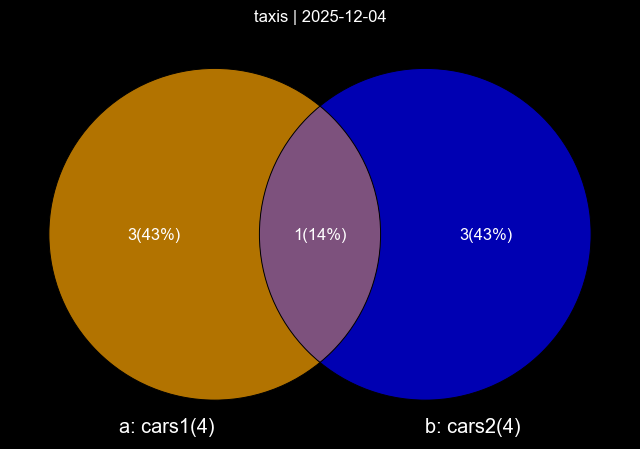

In [42]:
set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
_df, _details = ven.show_venn2(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    verbose=0,
    size=8,
)

abc --> cars1 | cars2 | cars3 --> len: 11
ab --> cars1 | cars2 --> len: 7
ac --> cars1 | cars3 --> len: 8
bc --> cars2 | cars3 --> len: 9


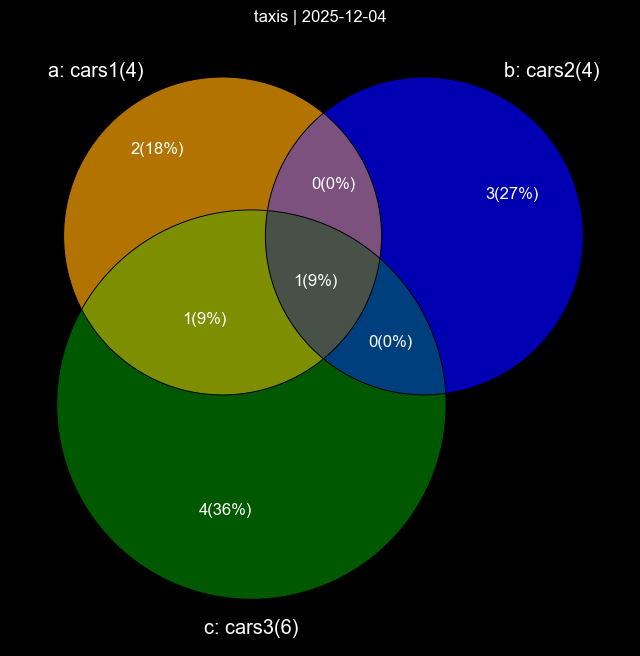

In [43]:
set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

## <a id='toc1_6_'></a>[hlp](#toc0_)

In [44]:
hlp.get_sparse_df()

## 📊 Sample Data & Explanation
---
### Original Sample DataFrame
This data represents various measurements (like 'Distance') grouped by a category ('Borough').
The goal is to restructure the data so that the 'Distance' values for each 'Borough' are in separate, comparable columns.
  Borough  Distance  ID
Manhattan       1.5 101
   Queens       5.1 102
Manhattan       0.8 103
    Bronx       3.2 104
   Queens       2.5 105
Manhattan       1.4 106
    Bronx       7.8 107
   Queens       4.0 108


### Sparse Pivoted DataFrame
The data has been **pivoted**:
* The non-numeric column **'Borough'** is used to create the new column names ('Bronx', 'Manhattan', 'Queens').
* The numeric column **'Distance'** provides the values for the new columns.
* A new index (**'Distance_sequence'**) is created to align the measurements within each 'Borough' group, allowing comparison of the 1st, 2nd, 3rd, etc., measurement across boroughs.
* `NaN` values appear where a borough has fewer measurements than ot

Borough,Bronx,Manhattan,Queens
Distance_sequence,,,
0,3.2,1.5,5.1
1,7.8,0.8,2.5
2,NaN,1.4,4.0


In [45]:
db_ops_kkr = con.sql("""--sql
    select
            z_kkr_label,
            ops.Code as ops_code,
            count(distinct OPSId) as cnt_ops,
            dim_ops.name as ops_name,
    from Tumor tum
    left join OP op on tum.z_tum_id = op.z_tum_id
    left join OPS ops on op.OPId = ops.OP_TypId
    left join dim_ops on dim_ops.code = ops.Code
    group by ops_code, z_kkr_label, ops_name
    """)
# tbl.descr_db(db_ops_kkr, "ops_kk")

# print(db_ops_kkr.aggregate("ops_code || ' - ' || ops_name as ops, sum(cnt_ops)::int as cnt_ops").order("cnt_ops desc").limit(10).to_df())
db_ops_kkr.aggregate("ops_code || ' - ' || ops_name as ops, sum(cnt_ops)::int as cnt_ops").order("cnt_ops desc").limit(10).show(max_width=120)
db_ops_kkr.aggregate("left(ops_code || ' - ' || ops_name,100) as ops, sum(cnt_ops)::int as cnt_ops").order("cnt_ops desc").limit(10).show()

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┬─────────┐
│                                                    ops                                                     │ cnt_ops │
│                                                  varchar                                                   │  int32  │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│ NULL                                                                                                       │  165429 │
│ 5-401.11 - Exzision einzelner Lymphknoten und Lymphgefäße: Axillär: Mit Radionuklidmarkierung (Sentinel-…  │  135826 │
│ 5-573.40 - Transurethrale Inzision, Exzision, Destruktion und Resektion von (erkranktem) Gewebe der Harn…  │   94266 │
│ 5-987.0 - Anwendung eines OP-Roboters: Komplexer OP-Roboter                                                │   82761 │
│ 5-870.a1 - Partielle (brusterh

In [46]:
df.pickup.to_series()

0      2019-03-23 20:21:09
1      2019-03-04 16:11:55
2      2019-03-27 17:53:01
3      2019-03-10 01:23:59
4      2019-03-30 13:27:42
               ...        
6428   2019-03-31 09:51:53
6429   2019-03-31 17:38:00
6430   2019-03-23 22:55:18
6431   2019-03-04 10:09:25
6432   2019-03-13 19:31:22
Name: pickup, Length: 6433, dtype: datetime64[ns]

In [47]:
hlp.get_tum_details("d90eb5e3-2791-420e-9682-69a8e9dfff9a", con)

tum_id: d90eb5e3-2791-420e-9682-69a8e9dfff9a

pat
┌──────────────────────────────────────┬─────────┬────────┬─────────┬────────────┬──────────────┬──────────────────────────┬───────────────────┬───────────────────────────────┐
│               z_pat_id               │  z_sex  │ z_age  │ z_ag05  │ Verstorben │ Geburtsdatum │ Geburtsdatum_Genauigkeit │ Datum_Vitalstatus │ Datum_Vitalstatus_Genauigkeit │
│               varchar                │ varchar │ double │ varchar │  varchar   │     date     │         varchar          │       date        │            varchar            │
├──────────────────────────────────────┼─────────┼────────┼─────────┼────────────┼──────────────┼──────────────────────────┼───────────────────┼───────────────────────────────┤
│ cb00a5de-22fd-495b-9375-bca43b0cab8a │ M       │  69.92 │ a65b69  │ N          │ 1950-06-15   │ T                        │ 2024-10-15        │ T                             │
└──────────────────────────────────────┴─────────┴────────┴──────

In [48]:
hlp.add_measures_to_pyg_config(".local/pygwalker_spec_.json", strict=False)

In [49]:
from pandas_plots import hlp
url="https://github.com/robert-koch-institut/Bundesweiter_klinischer_Krebsregisterdatensatz-Datenschema_und_Klassifikationen"
# url="http://google.com"

# hlp.create_barcode_from_url(
#     url=url,
#     output_path=".local/zfkd-repo.png",
#     show_image=True,
# )

In [50]:
hlp.find_cols(df, [
    "Tot",
    "DIS",
    ])


['total', 'distance']

In [51]:
# df
# from pandas_plots import hlp
hlp.add_datetime_columns(df,"dropoff")
# df

⏳ Adding datetime columns basing off of: dropoff


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,...,dropoff_borough,lol,xd,YYYY,MM,Q,YYYY-MM,YYYYQ,YYYY-WW,DDD
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,...,Manhattan,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W12,Sat
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,...,Manhattan,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W10,Mon
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,...,Manhattan,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W13,Wed
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,...,Manhattan,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W10,Sun
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,...,Manhattan,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W13,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,...,Manhattan,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,...,Bronx,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,...,Brooklyn,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W12,Sat
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,...,Brooklyn,NaN,2027,2019,3,1,2019-03,2019Q1,2019-W10,Mon


In [52]:
lol="""
The most important themes of the draft referendum are:
1. Improving the use of health data for research and innovation, particularly through the establishment of a National Data Access Point;
2. Enhancing the coordination and networking of different stakeholders involved in health data management;
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all areas of healthcare;
4. Providing better access to health data for patients and researchers, including through the development of a new law on health data protection;
5. Facilitating the exchange of health data between different countries and regions, particularly within the European Union (EU);
6. Ensuring that data are used in a way that promotes sustainable development and achieves the United Nations' Sustainable Development Goals (SDGs)."""

print(
hlp.wrap_text(
    text=lol,
    # max_items_in_line=40,
    use_sep=True,
    use_apo=True,
)
)

[The most important themes of the draft referendum are:  
1. Improving the use of health data for research and innovation particularly through  
the establishment of a National Data Access Point;  
2. Enhancing the coordination and networking of different stakeholders involved  
in health data management;  
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all  
areas of healthcare;  
4. Providing better access to health data for patients and researchers including through  
the development of a new law on health data protection;  
5. Facilitating the exchange of health data between different countries and regions  
particularly within the European Union (EU);  
6. Ensuring that data are used in a way that promotes sustainable development and achieves  
the United Nations Sustainable Development Goals (SDGs).]
